In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')


In [23]:
df = pd.read_csv('/content/train.csv')
display(df.head())
display(df.tail())


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [24]:
df.shape


(913000, 4)

In [25]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [26]:
df.describe()


,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [27]:
parts = df["date"].str.split("-", n = 3, expand = True)
df["year"]= parts[0].astype('int')
df["month"]= parts[1].astype('int')
df["day"]= parts[2].astype('int')
df.head()


,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [28]:
from datetime import datetime
import calendar

def weekend_or_weekday(year,month,day):

	d = datetime(year,month,day)
	if d.weekday()>4:
		return 1
	else:
		return 0

df['weekend'] = df.apply(lambda x:weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()


,date,store,item,sales,year,month,day,weekend
0,2013-01-01,1,1,13,2013,1,1,0
1,2013-01-02,1,1,11,2013,1,2,0
2,2013-01-03,1,1,14,2013,1,3,0
3,2013-01-04,1,1,13,2013,1,4,0
4,2013-01-05,1,1,10,2013,1,5,1


In [18]:
from datetime import date
import holidays
import pandas as pd

# Create a DataFrame with date column
df = pd.DataFrame({'date': pd.date_range(start='2023-01-01', end='2023-12-31')})

# Define a function to check holidays for a batch of dates
def is_holiday_batch(start_date, end_date):
    india_holidays = holidays.country_holidays('IN')
    df['holidays'] = df['date'].apply(lambda x: 1 if india_holidays.get(x) else 0)

# Process the DataFrame in batches
batch_size = 100
for start in range(0, len(df), batch_size):
    end = start + batch_size
    is_holiday_batch(df['date'].iloc[start:end], df['date'].iloc[start:end])

df.head()


,date,holidays
0,2023-01-01,0
1,2023-01-02,0
2,2023-01-03,0
3,2023-01-04,0
4,2023-01-05,0


In [29]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()


,date,store,item,sales,year,month,day,weekend,m1,m2
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,1,0.5,0.866025


In [30]:
def which_day(year, month, day):

	d = datetime(year,month,day)
	return d.weekday()

df['weekday'] = df.apply(lambda x: which_day(x['year'],
													x['month'],
													x['day']),
								axis=1)
df.head()


,date,store,item,sales,year,month,day,weekend,m1,m2,weekday
0,2013-01-01,1,1,13,2013,1,1,0,0.5,0.866025,1
1,2013-01-02,1,1,11,2013,1,2,0,0.5,0.866025,2
2,2013-01-03,1,1,14,2013,1,3,0,0.5,0.866025,3
3,2013-01-04,1,1,13,2013,1,4,0,0.5,0.866025,4
4,2013-01-05,1,1,10,2013,1,5,1,0.5,0.866025,5


In [31]:
df.drop('date', axis=1, inplace=True)


In [32]:
df['store'].nunique(), df['item'].nunique()


(10, 50)

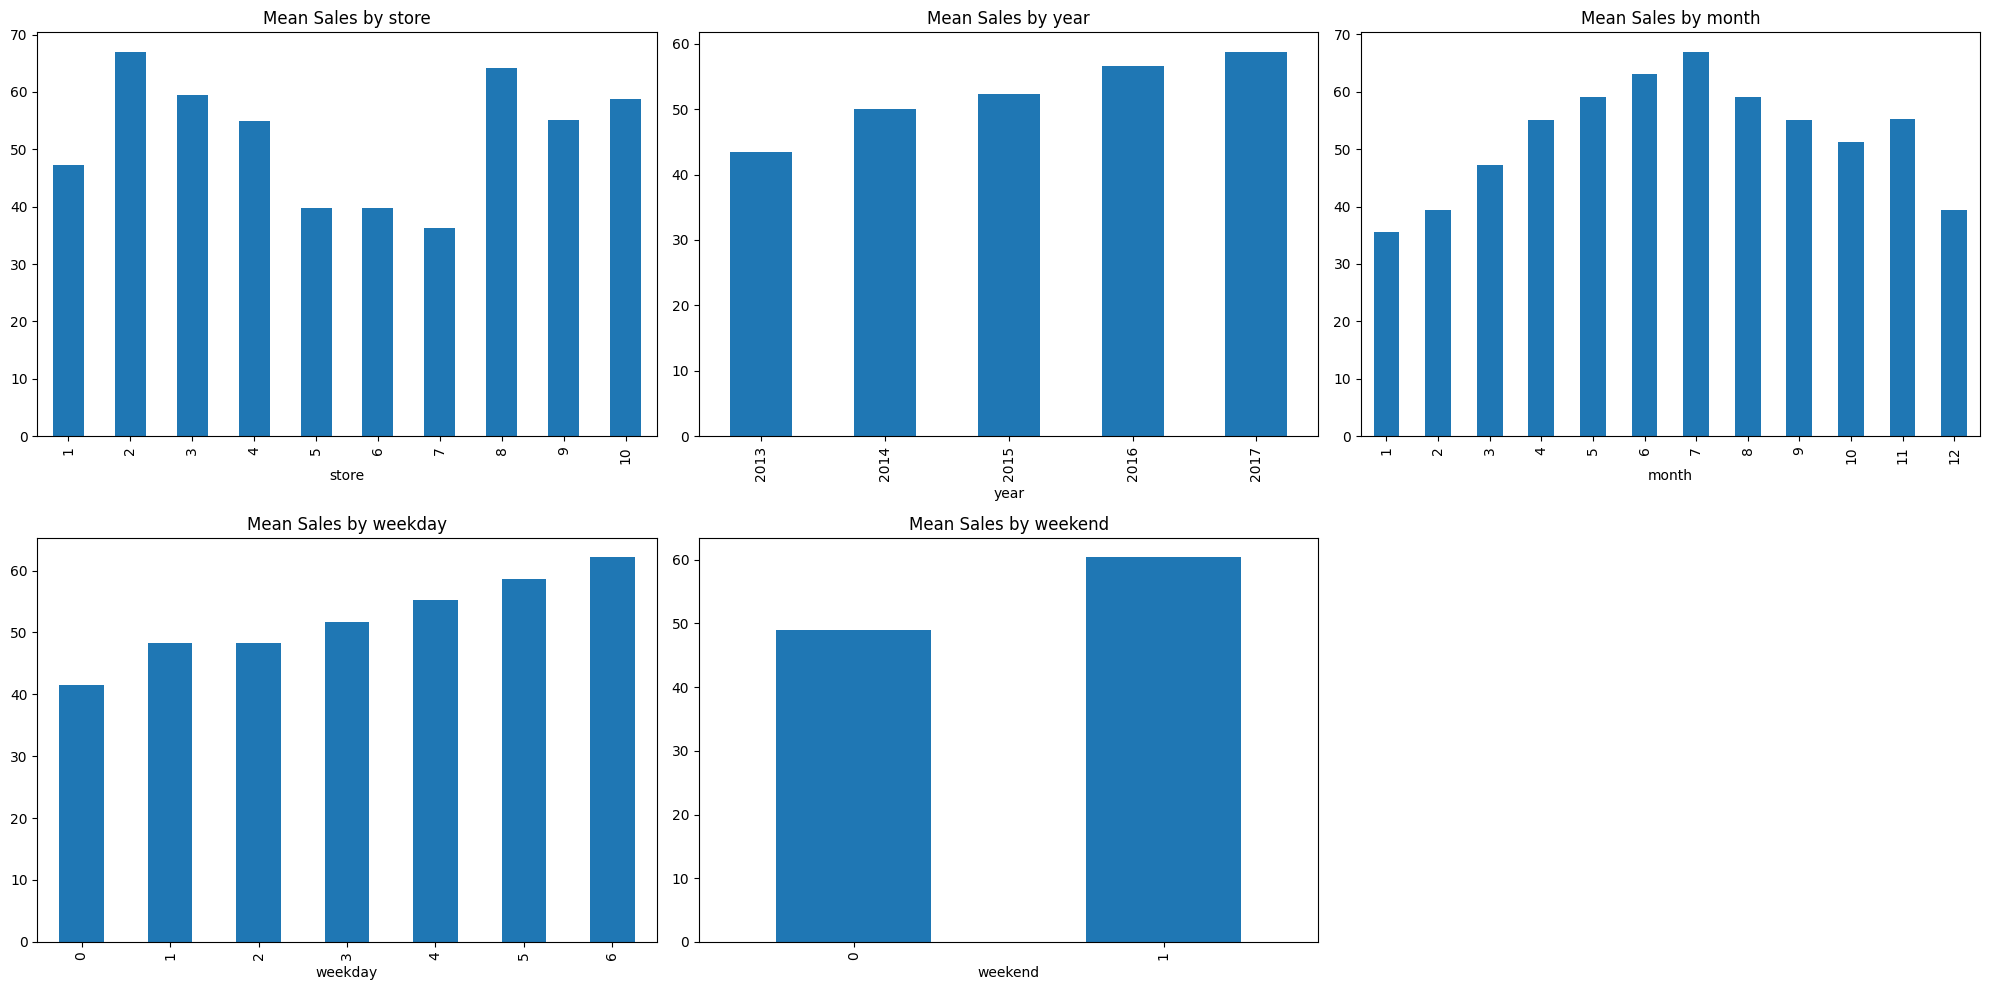

In [34]:
import matplotlib.pyplot as plt

features = ['store', 'year', 'month', 'weekday', 'weekend']

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Flatten the 2D axes array for easier indexing
axes = axes.flatten()

for i, col in enumerate(features):
    if col in df:
        df.groupby(col).mean()['sales'].plot.bar(ax=axes[i])
        axes[i].set_title(f'Mean Sales by {col}')

# Remove any extra empty subplots
for j in range(len(features), 6):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


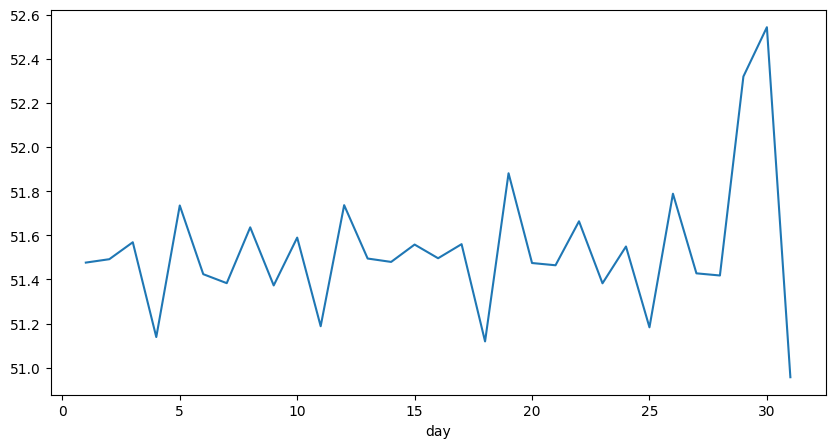

In [43]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()


In [ ]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()


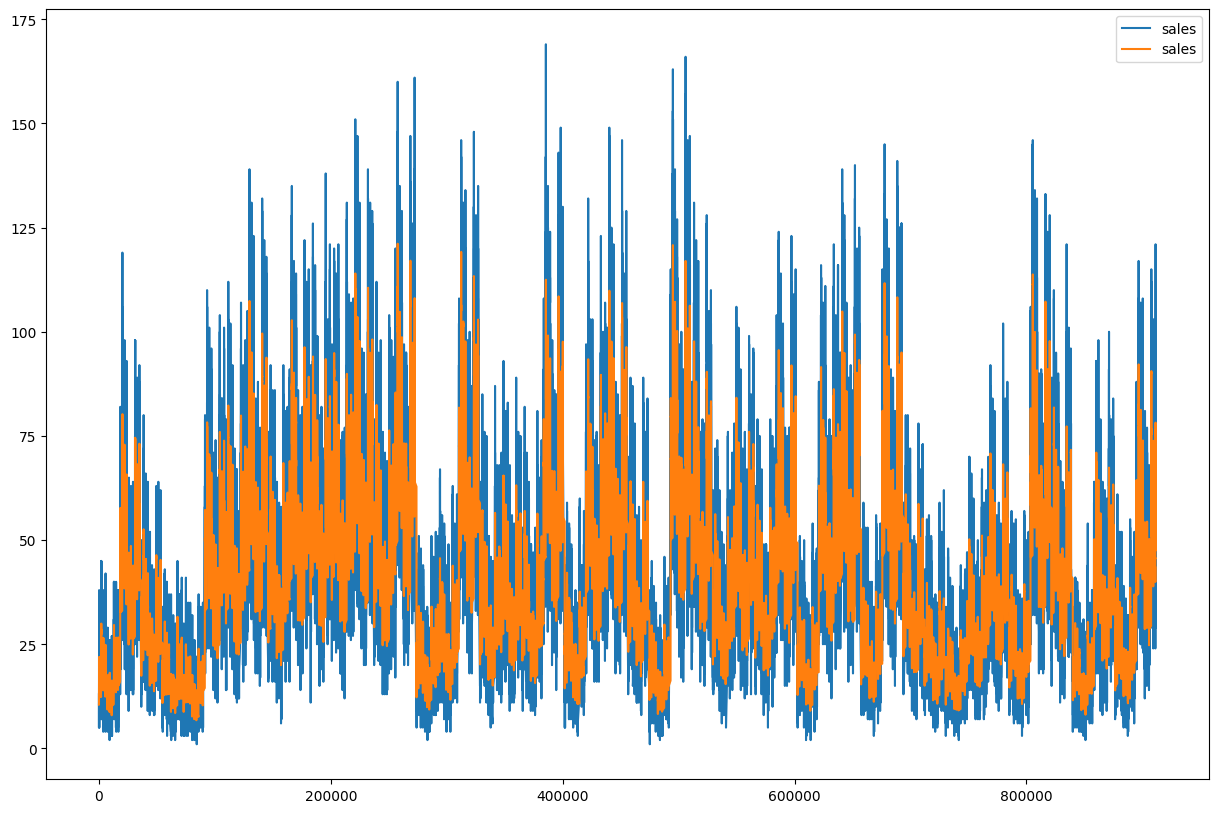

In [36]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()


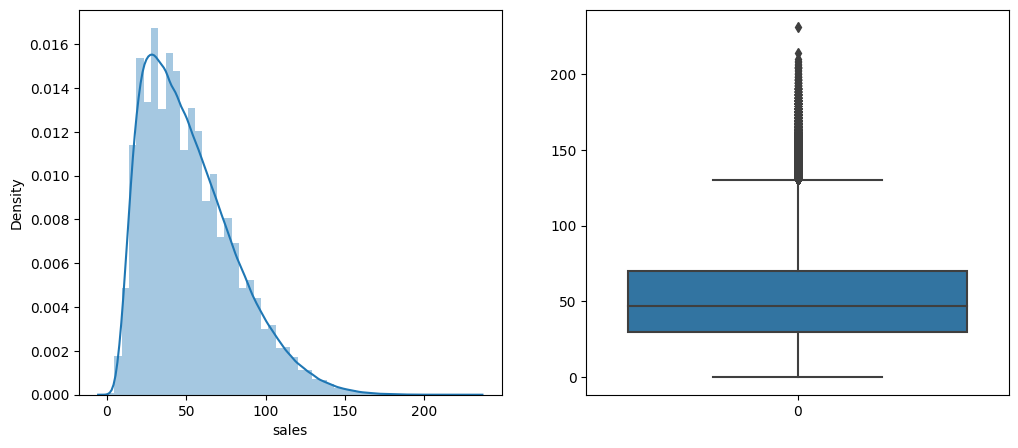

In [37]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()


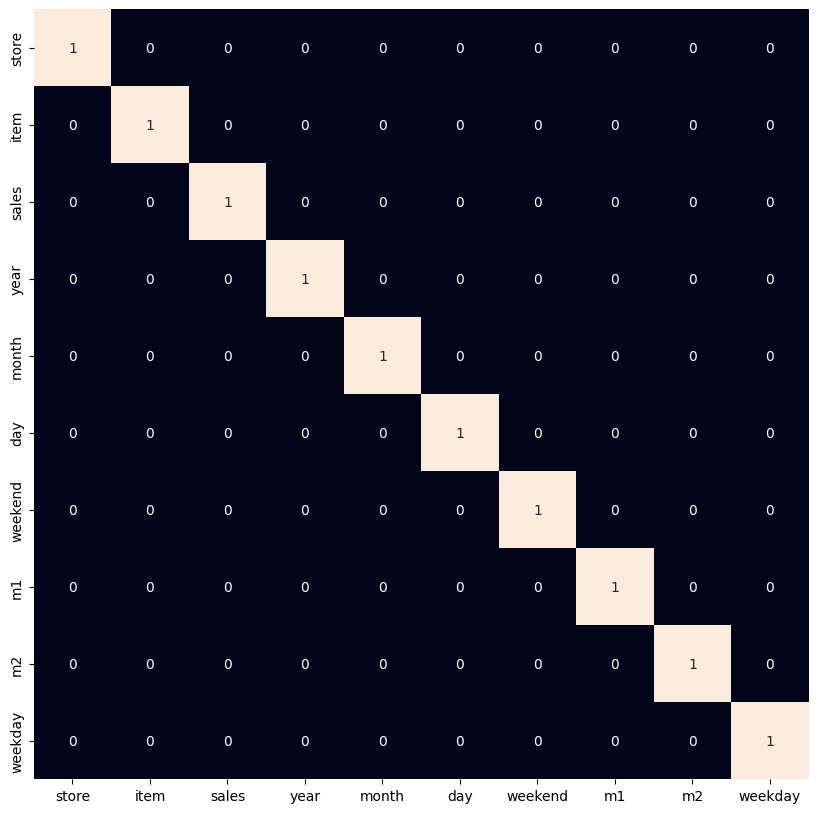

In [38]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
		annot=True,
		cbar=False)
plt.show()


In [39]:
df = df[df['sales']<140]


In [40]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
												test_size = 0.05,
												random_state=22)
X_train.shape, X_val.shape


((861170, 8), (45325, 8))

In [41]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [42]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
	models[i].fit(X_train, Y_train)

	print(f'{models[i]} : ')

	train_preds = models[i].predict(X_train)
	print('Training Error : ', mae(Y_train, train_preds))

	val_preds = models[i].predict(X_val)
	print('Validation Error : ', mae(Y_val, val_preds))
	print()


LinearRegression() : 
Training Error :  20.903004582954193
Validation Error :  20.971906433303552

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) : 
Training Error :  6.862874663759986
Validation Error :  6.88620016190076

Lasso() : 
Training Error :  21.015028699769758
Validation Error :  21.071517